# Euclidean space

* Load original embeddings
* Euclidean MDS

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns
from sklearn.manifold import MDS
from scipy import stats
from scipy.spatial import distance_matrix

data_dir = '../data'
output_dir = '../outputs'

In [2]:
input_distance_matrix = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
input_distance_matrix.shape

(49, 49)

In [3]:
embedding = MDS(n_components=16)
transformed_dist = embedding.fit_transform(input_distance_matrix)
# eu_dist = np.corrcoef(transformed_dist, rowvar=True)
# eu_dist = 1 - abs(eu_dist)
eu_dist = distance_matrix(transformed_dist, transformed_dist)

stats.spearmanr(eu_dist.flatten(),input_distance_matrix.flatten()) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


SpearmanrResult(correlation=0.5077595707596154, pvalue=1.5194883248693213e-157)

In [4]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [5]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [6]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


# Analysis

1. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
2. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        


In [7]:
### normalize embeddings and transform concept embeddings to loadings in feature space
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
concept_in_feat_coord = normalized_embeddings@transformed_dist
np.array(concept_in_feat_coord).shape

(1854, 16)

In [8]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(concept_in_feat_coord).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cr,bigcat,cat_name
0,0,-0.366585,-0.158296,0.121544,0.253874,0.190135,-0.180864,-0.310861,-0.274049,0.351622,-0.044140,-0.071439,-0.048424,-0.135241,-0.056327,-0.396683,-0.534734,0.779739,1,animal
1,1,-0.365991,-0.138092,-0.154587,-0.179472,0.003389,-0.199598,-0.471627,-0.105171,0.338215,-0.217297,-0.073137,0.129281,0.175042,-0.433492,0.153084,-0.341237,0.798485,13,home decor
2,2,-0.200085,-0.070790,0.044368,-0.300131,0.413793,-0.041209,-0.350442,-0.260371,0.339943,-0.358853,-0.217621,0.030174,0.327486,-0.314035,0.002191,-0.237887,0.752845,18,musical instrument
4,4,-0.451710,0.210000,0.138993,-0.193453,-0.397502,-0.070541,-0.349433,-0.240464,0.243474,0.305076,-0.376573,-0.168951,0.076296,0.045686,-0.072380,-0.503629,0.794466,9,electronic device
5,5,-0.201025,0.090914,-0.183967,-0.168119,-0.071064,-0.193834,-0.033169,-0.097548,0.289356,0.090151,-0.455078,-0.139217,-0.052921,0.103761,-0.000181,-0.168765,0.806000,12,furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,0.166145,-0.329185,-0.005621,0.021008,0.279589,-0.274487,0.048595,0.423518,0.201972,0.053543,0.320213,0.013151,0.015493,0.069172,0.094520,-0.353035,0.803129,24,toy
1848,1848,-0.106562,0.103634,-0.060882,-0.436415,0.268120,-0.072461,0.053200,-0.368112,0.273707,-0.266837,-0.020391,0.231160,-0.066698,0.393517,-0.053204,-0.408261,0.765881,10,food
1850,1850,-0.163918,0.125510,-0.109042,-0.302600,0.212189,-0.130890,-0.020709,-0.239521,0.317717,-0.218678,0.038571,0.115677,-0.070735,0.201057,0.054837,-0.510615,0.843158,10,food
1851,1851,-0.239129,-0.162565,0.176055,0.211904,0.102780,0.040593,-0.373640,-0.235435,0.349816,-0.009526,-0.116287,-0.139270,-0.130208,-0.142970,-0.338252,-0.444206,0.800163,1,animal


### Cartesian

In [9]:
coordinates = mean_concept_in_feat_cat.loc[:, 0:15]
coordinates

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.366585,-0.158296,0.121544,0.253874,0.190135,-0.180864,-0.310861,-0.274049,0.351622,-0.044140,-0.071439,-0.048424,-0.135241,-0.056327,-0.396683,-0.534734
1,-0.365991,-0.138092,-0.154587,-0.179472,0.003389,-0.199598,-0.471627,-0.105171,0.338215,-0.217297,-0.073137,0.129281,0.175042,-0.433492,0.153084,-0.341237
2,-0.200085,-0.070790,0.044368,-0.300131,0.413793,-0.041209,-0.350442,-0.260371,0.339943,-0.358853,-0.217621,0.030174,0.327486,-0.314035,0.002191,-0.237887
3,-0.129532,0.084294,-0.416706,-0.455131,0.187125,-0.258828,-0.123043,-0.170393,0.477688,-0.126347,-0.121016,-0.013984,0.247002,-0.077769,0.055205,-0.333611
4,-0.451710,0.210000,0.138993,-0.193453,-0.397502,-0.070541,-0.349433,-0.240464,0.243474,0.305076,-0.376573,-0.168951,0.076296,0.045686,-0.072380,-0.503629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,-0.212490,0.144308,-0.184119,-0.507078,0.316642,-0.530260,-0.215078,-0.182588,0.250568,-0.176804,-0.112054,0.255870,0.118501,-0.150066,0.052447,-0.540010
1850,-0.163918,0.125510,-0.109042,-0.302600,0.212189,-0.130890,-0.020709,-0.239521,0.317717,-0.218678,0.038571,0.115677,-0.070735,0.201057,0.054837,-0.510615
1851,-0.239129,-0.162565,0.176055,0.211904,0.102780,0.040593,-0.373640,-0.235435,0.349816,-0.009526,-0.116287,-0.139270,-0.130208,-0.142970,-0.338252,-0.444206
1852,-0.312242,0.355090,0.034502,-0.148432,0.362095,-0.469896,-0.153068,-0.216391,0.457494,-0.057977,-0.120277,0.077422,-0.086725,0.247178,-0.181813,-0.215190


In [10]:
### linreg: cartesian coordinates and z-score memorability
# Euclidean: R^2 = 0.271, adjusted = 0.265
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(coordinates, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     43.88
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          1.07e-116
Time:                        14:27:54   Log-Likelihood:                -2330.6
No. Observations:                1854   AIC:                             4695.
Df Residuals:                    1837   BIC:                             4789.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4092      0.116     -3.528      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
### create a new table to store all regression results
results_index = ['rsquared', 'rsquared_adj', 'coef', 'pvalues', 'AIC', 'BIC', 'F-statistic', 'F-stats-prob', 'Log-Likelihood']
results = pd.DataFrame({'cart_coord_mem':[res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]}, index=results_index)
results

,cart_coord_mem
rsquared,0.276532
rsquared_adj,0.27023
coef,"[-0.4091841288432847, -0.14202683838730545, 0...."
pvalues,"[0.00042933242848608634, 0.26482541534924803, ..."
AIC,4695.286803
BIC,4789.213516
F-statistic,43.884862
F-stats-prob,0.0
Log-Likelihood,-2330.643402


### Polar coordinates

In [12]:
# ### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(coordinates.values).T
# plt.hist2d(theta, rho,
#            bins = 20)

### Radius
small R^2, with concepts closer to the core/origin being more memorable

<IPython.core.display.Javascript object>


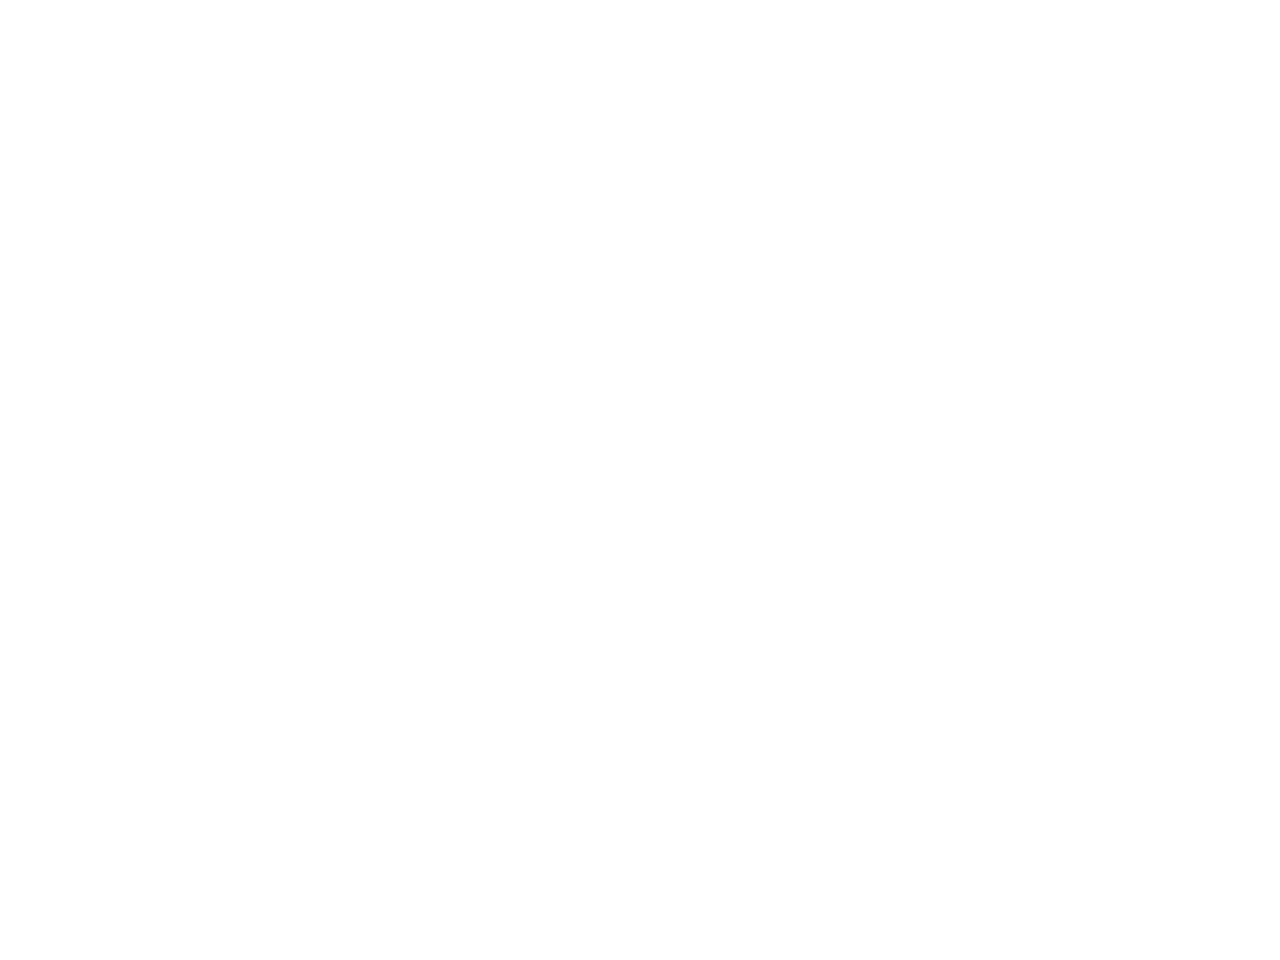

(array([ 13.,  41., 126., 264., 469., 436., 288., 149.,  62.,   6.]),
 array([0.57379514, 0.66500777, 0.7562204 , 0.84743303, 0.93864566,
        1.02985829, 1.12107092, 1.21228355, 1.30349618, 1.39470881,
        1.48592144]),
 <BarContainer object of 10 artists>)

In [13]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((coordinates**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [14]:
### Radius vs. memorability
# Euclidean: R^2 = 0.006, adjsuted = 0.005
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     6.125
Date:                Wed, 05 Oct 2022   Prob (F-statistic):             0.0134
Time:                        14:27:54   Log-Likelihood:                -2627.7
No. Observations:                1854   AIC:                             5259.
Df Residuals:                    1852   BIC:                             5270.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3970      0.160     -2.475      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [15]:
results['radius_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]
results


,cart_coord_mem,radius_mem
rsquared,0.276532,0.003296
rsquared_adj,0.27023,0.002758
coef,"[-0.4091841288432847, -0.14202683838730545, 0....","[-0.3969957347826868, 0.4111984488295847]"
pvalues,"[0.00042933242848608634, 0.26482541534924803, ...","[0.013418350014305951, 0.014335137778896901]"
AIC,4695.286803,5259.302727
BIC,4789.213516,5270.352928
F-statistic,43.884862,6.124857
F-stats-prob,0.0,0.013418
Log-Likelihood,-2330.643402,-2627.651363


### KMeans

In [16]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(coordinates)
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)
print(inertia)

[1417.7888846783064, 1209.214138431486, 1076.9746655774918, 1000.6255504050748, 931.9740157693432, 877.799636847308, 830.2260443553878, 795.7197667638317, 762.6554357265052, 737.0312764472278, 717.1442241097648, 700.0225236746444, 686.9440185214809, 672.6892928983776]


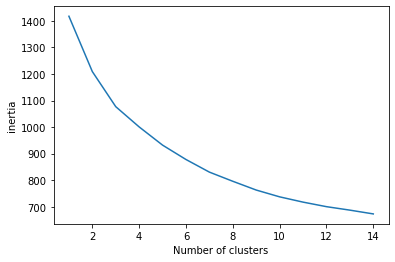

In [17]:
%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()
    

In [18]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(coordinates)
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[-0.28587495,  0.13566037,  0.00622747, -0.40406137,  0.23149802,
        -0.17515573, -0.13599514, -0.18624911,  0.20800664, -0.19536951,
        -0.0163658 ,  0.11430836,  0.07480484,  0.1249774 , -0.02058275,
        -0.39021417],
       [ 0.01334006,  0.26544188, -0.24483232,  0.10417627,  0.02691878,
        -0.22370408,  0.13116819, -0.19822742,  0.39399787,  0.02257994,
        -0.01094288,  0.18063503, -0.15686711,  0.34506383, -0.21659527,
         0.18431383],
       [-0.10742946,  0.10641158, -0.08450669, -0.13601717,  0.07047299,
        -0.07256005, -0.17106215,  0.03122134,  0.18902347, -0.1111065 ,
        -0.06324341,  0.06359031, -0.0196968 , -0.16926863, -0.00222437,
        -0.11192651],
       [-0.29146155,  0.0423824 ,  0.09104866,  0.12348496,  0.15918347,
        -0.19395475, -0.37365922, -0.2402986 ,  0.24155031, -0.07180669,
        -0.17647544, -0.11051105, -0.04040111,  0.00526725, -0.27968572,
        -0.33659178]])

In [19]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:15], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     19.23
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           8.59e-47
Time:                        14:27:56   Log-Likelihood:                -1057.1
No. Observations:                 839   AIC:                             2148.
Df Residuals:                     822   BIC:                             2229.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.4793      0.222      2.160      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
results['cluster_cart_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]
results

,cart_coord_mem,radius_mem,cluster_cart_mem
rsquared,0.276532,0.003296,[0.272374424603374]
rsquared_adj,0.27023,0.002758,[0.25821139637180957]
coef,"[-0.4091841288432847, -0.14202683838730545, 0....","[-0.3969957347826868, 0.4111984488295847]","[[0.4792594086520734, -0.2750483080577154, 0.7..."
pvalues,"[0.00042933242848608634, 0.26482541534924803, ...","[0.013418350014305951, 0.014335137778896901]","[[0.031089562558423534, 0.26098055027890554, 0..."
AIC,4695.286803,5259.302727,[2148.203134013333]
BIC,4789.213516,5270.352928,[2228.6507160232754]
F-statistic,43.884862,6.124857,[19.231369178262703]
F-stats-prob,0.0,0.013418,[8.594841356640513e-47]
Log-Likelihood,-2330.643402,-2627.651363,[-1057.1015670066665]


In [21]:
### cluster 0: radius vs. memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     45.21
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.28e-11
Time:                        14:27:56   Log-Likelihood:                -1168.4
No. Observations:                 839   AIC:                             2341.
Df Residuals:                     837   BIC:                             2350.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.6142      0.240     -6.724      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [22]:
results['cluster_radius_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]
results

,cart_coord_mem,radius_mem,cluster_cart_mem,cluster_radius_mem
rsquared,0.276532,0.003296,[0.272374424603374],[0.05124279861007697]
rsquared_adj,0.27023,0.002758,[0.25821139637180957],[0.050109277461462876]
coef,"[-0.4091841288432847, -0.14202683838730545, 0....","[-0.3969957347826868, 0.4111984488295847]","[[0.4792594086520734, -0.2750483080577154, 0.7...","[[-1.614202911401734, 1.7371096440995133]]"
pvalues,"[0.00042933242848608634, 0.26482541534924803, ...","[0.013418350014305951, 0.014335137778896901]","[[0.031089562558423534, 0.26098055027890554, 0...","[[3.2804097145128915e-11, 4.729717323598735e-11]]"
AIC,4695.286803,5259.302727,[2148.203134013333],[2340.8454787585774]
BIC,4789.213516,5270.352928,[2228.6507160232754],[2350.309900171512]
F-statistic,43.884862,6.124857,[19.231369178262703],[45.20674243505138]
F-stats-prob,0.0,0.013418,[8.594841356640513e-47],[3.280409714512634e-11]
Log-Likelihood,-2330.643402,-2627.651363,[-1057.1015670066665],[-1168.4227393792887]


In [23]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:15], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     7.859
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           5.28e-15
Time:                        14:27:56   Log-Likelihood:                -318.89
No. Observations:                 263   AIC:                             671.8
Df Residuals:                     246   BIC:                             732.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1859      0.362     -0.513      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [24]:
row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [25]:
### cluster 1: radius vs. memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     28.43
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.10e-07
Time:                        14:27:56   Log-Likelihood:                -359.58
No. Observations:                 263   AIC:                             723.2
Df Residuals:                     261   BIC:                             730.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.2968      0.431      5.332      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [27]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:15], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     7.027
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.96e-14
Time:                        14:27:56   Log-Likelihood:                -572.48
No. Observations:                 440   AIC:                             1179.
Df Residuals:                     423   BIC:                             1248.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1086      0.241     -0.450      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [29]:
### cluster 2: radius vs. memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     7.540
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00628
Time:                        14:27:56   Log-Likelihood:                -620.58
No. Observations:                 440   AIC:                             1245.
Df Residuals:                     438   BIC:                             1253.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.0195      0.371     -2.746      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [30]:
row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [31]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:15], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     5.071
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.58e-09
Time:                        14:27:56   Log-Likelihood:                -404.80
No. Observations:                 312   AIC:                             843.6
Df Residuals:                     295   BIC:                             907.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.4482      0.368     -3.939      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [32]:
row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [33]:
### cluster 3: radius vs. memorability
radius_cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(radius_cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_3.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.386
Date:                Wed, 05 Oct 2022   Prob (F-statistic):              0.240
Time:                        14:27:56   Log-Likelihood:                -442.01
No. Observations:                 312   AIC:                             888.0
Df Residuals:                     310   BIC:                             895.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.5953      0.506     -1.177      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [35]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_mem'].append(r_squared)
r_squared

0.2573808250840759

In [36]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_mem'].append(r_squared)
r_squared

0.04188987913556408

### Typicality

In [37]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [38]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,cr,bigcat,cat_name,typicality
0,0,-0.366585,-0.158296,0.121544,0.253874,0.190135,-0.180864,-0.310861,-0.274049,0.351622,...,-0.071439,-0.048424,-0.135241,-0.056327,-0.396683,-0.534734,0.779739,1,animal,0.810913
1,1,-0.365991,-0.138092,-0.154587,-0.179472,0.003389,-0.199598,-0.471627,-0.105171,0.338215,...,-0.073137,0.129281,0.175042,-0.433492,0.153084,-0.341237,0.798485,13,home decor,0.247628
2,2,-0.200085,-0.070790,0.044368,-0.300131,0.413793,-0.041209,-0.350442,-0.260371,0.339943,...,-0.217621,0.030174,0.327486,-0.314035,0.002191,-0.237887,0.752845,18,musical instrument,0.624589
4,4,-0.451710,0.210000,0.138993,-0.193453,-0.397502,-0.070541,-0.349433,-0.240464,0.243474,...,-0.376573,-0.168951,0.076296,0.045686,-0.072380,-0.503629,0.794466,9,electronic device,0.522380
5,5,-0.201025,0.090914,-0.183967,-0.168119,-0.071064,-0.193834,-0.033169,-0.097548,0.289356,...,-0.455078,-0.139217,-0.052921,0.103761,-0.000181,-0.168765,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,0.166145,-0.329185,-0.005621,0.021008,0.279589,-0.274487,0.048595,0.423518,0.201972,...,0.320213,0.013151,0.015493,0.069172,0.094520,-0.353035,0.803129,24,toy,0.246697
1848,1848,-0.106562,0.103634,-0.060882,-0.436415,0.268120,-0.072461,0.053200,-0.368112,0.273707,...,-0.020391,0.231160,-0.066698,0.393517,-0.053204,-0.408261,0.765881,10,food,0.786900
1850,1850,-0.163918,0.125510,-0.109042,-0.302600,0.212189,-0.130890,-0.020709,-0.239521,0.317717,...,0.038571,0.115677,-0.070735,0.201057,0.054837,-0.510615,0.843158,10,food,0.770485
1851,1851,-0.239129,-0.162565,0.176055,0.211904,0.102780,0.040593,-0.373640,-0.235435,0.349816,...,-0.116287,-0.139270,-0.130208,-0.142970,-0.338252,-0.444206,0.800163,1,animal,0.764335


In [39]:
### Cartesian coordinates vs. typicality
# Euclidean: R^2 = 0.492, adjusted = 0.485
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped.loc[:, 0:15], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     68.71
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          2.57e-160
Time:                        14:27:56   Log-Likelihood:                -1474.6
No. Observations:                1324   AIC:                             2983.
Df Residuals:                    1307   BIC:                             3071.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2542      0.128     -1.987      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [40]:
### Radius vs. typicality
# Euclidean: R^2 = 0.023, adjusted = 0.023
# normalized: R^2 = 0.388, adjusted = 0.388

concept_radius_typ = np.sqrt((grouped.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     10.30
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00136
Time:                        14:27:56   Log-Likelihood:                -1873.5
No. Observations:                1324   AIC:                             3751.
Df Residuals:                    1322   BIC:                             3761.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.6049      0.188      3.210      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
### Cartesian coordinates and typicality vs. memorability
# Euclidean: R^2 = 0.301, adjusted = 0.292
# normalized: R^2 = 0.107, adjusted = 0.104

zscore_mem = stats.zscore(grouped['cr'])
idx = [i for i in range(0, 16)]
idx.append('typicality')
mean_concept_constant = sm.add_constant(np.array(grouped[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     35.72
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           9.57e-96
Time:                        14:27:56   Log-Likelihood:                -1625.9
No. Observations:                1324   AIC:                             3288.
Df Residuals:                    1306   BIC:                             3381.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2941      0.144     -2.046      0.0

In [42]:
### Radius and typicality vs. memorability
# Euclidean: R^2 = 0.041, adjusted = 0.040
# normalized: R^2 = 0.046, adjusted = 0.044

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], concept_radius_typ]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     24.56
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.36e-11
Time:                        14:27:56   Log-Likelihood:                -1854.5
No. Observations:                1324   AIC:                             3715.
Df Residuals:                    1321   BIC:                             3731.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9828      0.145      6.799      0.0

##### Cluster level typicality

In [43]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,-0.366585,-0.158296,0.121544,0.253874,0.190135,-0.180864,-0.310861,-0.274049,0.351622,...,-0.048424,-0.135241,-0.056327,-0.396683,-0.534734,0.779739,1,animal,3,0.810913
1,1,-0.365991,-0.138092,-0.154587,-0.179472,0.003389,-0.199598,-0.471627,-0.105171,0.338215,...,0.129281,0.175042,-0.433492,0.153084,-0.341237,0.798485,13,home decor,2,0.247628
2,2,-0.200085,-0.070790,0.044368,-0.300131,0.413793,-0.041209,-0.350442,-0.260371,0.339943,...,0.030174,0.327486,-0.314035,0.002191,-0.237887,0.752845,18,musical instrument,0,0.624589
3,4,-0.451710,0.210000,0.138993,-0.193453,-0.397502,-0.070541,-0.349433,-0.240464,0.243474,...,-0.168951,0.076296,0.045686,-0.072380,-0.503629,0.794466,9,electronic device,3,0.522380
4,5,-0.201025,0.090914,-0.183967,-0.168119,-0.071064,-0.193834,-0.033169,-0.097548,0.289356,...,-0.139217,-0.052921,0.103761,-0.000181,-0.168765,0.806000,12,furniture,2,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.166145,-0.329185,-0.005621,0.021008,0.279589,-0.274487,0.048595,0.423518,0.201972,...,0.013151,0.015493,0.069172,0.094520,-0.353035,0.803129,24,toy,2,0.246697
1320,1848,-0.106562,0.103634,-0.060882,-0.436415,0.268120,-0.072461,0.053200,-0.368112,0.273707,...,0.231160,-0.066698,0.393517,-0.053204,-0.408261,0.765881,10,food,0,0.786900
1321,1850,-0.163918,0.125510,-0.109042,-0.302600,0.212189,-0.130890,-0.020709,-0.239521,0.317717,...,0.115677,-0.070735,0.201057,0.054837,-0.510615,0.843158,10,food,0,0.770485
1322,1851,-0.239129,-0.162565,0.176055,0.211904,0.102780,0.040593,-0.373640,-0.235435,0.349816,...,-0.139270,-0.130208,-0.142970,-0.338252,-0.444206,0.800163,1,animal,3,0.764335


In [44]:
### cluster 0: cartesian coordinates + typicality vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[idx], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     15.01
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.25e-36
Time:                        14:27:56   Log-Likelihood:                -809.32
No. Observations:                 648   AIC:                             1655.
Df Residuals:                     630   BIC:                             1735.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.4575      0.278      1.644      0.1

In [45]:
### cluster 0: radius + typicality vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     34.51
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           5.76e-15
Time:                        14:27:56   Log-Likelihood:                -886.53
No. Observations:                 648   AIC:                             1779.
Df Residuals:                     645   BIC:                             1792.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.3212      0.267     -4.951      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [46]:
### cluster 1: cartesian coordinates + typicality vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[idx], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     4.740
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.26e-08
Time:                        14:27:56   Log-Likelihood:                -235.90
No. Observations:                 192   AIC:                             507.8
Df Residuals:                     174   BIC:                             566.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.5219      0.492      1.061      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [47]:
### cluster 1: radius + typicality vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:15]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     9.177
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           0.000157
Time:                        14:27:56   Log-Likelihood:                -263.54
No. Observations:                 192   AIC:                             533.1
Df Residuals:                     189   BIC:                             542.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.0300      0.639      1.611      0.1

In [48]:
### cluster 2: cartesian coordinates + typicality vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[idx], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     6.041
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.60e-11
Time:                        14:27:56   Log-Likelihood:                -279.53
No. Observations:                 229   AIC:                             595.1
Df Residuals:                     211   BIC:                             656.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2230      0.330      0.676      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [49]:
### cluster 2: radius + typicality vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:15]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.334
Date:                Wed, 05 Oct 2022   Prob (F-statistic):              0.265
Time:                        14:27:56   Log-Likelihood:                -323.59
No. Observations:                 229   AIC:                             653.2
Df Residuals:                     226   BIC:                             663.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7959      0.509     -1.562      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [50]:
### cluster 3: cartesian coordinates + typicality vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[idx], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     7.038
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           9.69e-14
Time:                        14:27:56   Log-Likelihood:                -309.72
No. Observations:                 255   AIC:                             655.4
Df Residuals:                     237   BIC:                             719.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.2471      0.417     -2.989      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [51]:
### cluster 3: radius + typicality vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     19.15
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.81e-08
Time:                        14:27:56   Log-Likelihood:                -343.79
No. Observations:                 255   AIC:                             693.6
Df Residuals:                     252   BIC:                             704.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.8979      0.552     -1.628      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Taking typicality into account, on cluster level, coordinates and typicality of concepts in euclidean space explained more variance in memorability compared to coordinates only. 

In [52]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_typ_mem'].append(r_squared)
r_squared

0.30819514445414997

In [53]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

0.08758013038115642

In [54]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     22.69
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.05e-10
Time:                        14:27:56   Log-Likelihood:                -1856.3
No. Observations:                1324   AIC:                             3719.
Df Residuals:                    1321   BIC:                             3734.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0291      0.023      1.281      0.2

### Typicality calculated by cluster

In [55]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,-0.366585,-0.158296,0.121544,0.253874,0.190135,-0.180864,-0.310861,-0.274049,0.351622,...,-0.048424,-0.135241,-0.056327,-0.396683,-0.534734,0.779739,1,animal,3,0.552864
1,1,-0.365991,-0.138092,-0.154587,-0.179472,0.003389,-0.199598,-0.471627,-0.105171,0.338215,...,0.129281,0.175042,-0.433492,0.153084,-0.341237,0.798485,13,home decor,2,0.179082
2,2,-0.200085,-0.070790,0.044368,-0.300131,0.413793,-0.041209,-0.350442,-0.260371,0.339943,...,0.030174,0.327486,-0.314035,0.002191,-0.237887,0.752845,18,musical instrument,0,0.095533
3,4,-0.451710,0.210000,0.138993,-0.193453,-0.397502,-0.070541,-0.349433,-0.240464,0.243474,...,-0.168951,0.076296,0.045686,-0.072380,-0.503629,0.794466,9,electronic device,3,0.046823
4,5,-0.201025,0.090914,-0.183967,-0.168119,-0.071064,-0.193834,-0.033169,-0.097548,0.289356,...,-0.139217,-0.052921,0.103761,-0.000181,-0.168765,0.806000,12,furniture,2,0.132569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.166145,-0.329185,-0.005621,0.021008,0.279589,-0.274487,0.048595,0.423518,0.201972,...,0.013151,0.015493,0.069172,0.094520,-0.353035,0.803129,24,toy,2,0.079511
1320,1848,-0.106562,0.103634,-0.060882,-0.436415,0.268120,-0.072461,0.053200,-0.368112,0.273707,...,0.231160,-0.066698,0.393517,-0.053204,-0.408261,0.765881,10,food,0,0.368921
1321,1850,-0.163918,0.125510,-0.109042,-0.302600,0.212189,-0.130890,-0.020709,-0.239521,0.317717,...,0.115677,-0.070735,0.201057,0.054837,-0.510615,0.843158,10,food,0,0.336868
1322,1851,-0.239129,-0.162565,0.176055,0.211904,0.102780,0.040593,-0.373640,-0.235435,0.349816,...,-0.139270,-0.130208,-0.142970,-0.338252,-0.444206,0.800163,1,animal,3,0.519992


In [56]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     35.28
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.16e-94
Time:                        14:27:56   Log-Likelihood:                -1628.5
No. Observations:                1324   AIC:                             3293.
Df Residuals:                    1306   BIC:                             3386.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2521      0.145     -1.739      0.0

In [57]:
### overall cartesian vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx[:-1]]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     144.7
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          2.35e-275
Time:                        14:27:56   Log-Likelihood:                -1203.9
No. Observations:                1324   AIC:                             2442.
Df Residuals:                    1307   BIC:                             2530.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4762      0.104     -4.566      0.0

In [58]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     94.10
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           6.23e-39
Time:                        14:27:56   Log-Likelihood:                -1790.5
No. Observations:                1324   AIC:                             3587.
Df Residuals:                    1321   BIC:                             3603.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6898      0.179     -3.849      0.0

In [59]:
### overall radius vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_clus, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     31.75
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.14e-08
Time:                        14:27:56   Log-Likelihood:                -1863.0
No. Observations:                1324   AIC:                             3730.
Df Residuals:                    1322   BIC:                             3740.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.0535      0.187      5.634      0.0

In [60]:
### cluster 0: cartesian coordinates and typicality vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_0[idx]), prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_clust_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     14.86
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.82e-36
Time:                        14:27:56   Log-Likelihood:                -810.21
No. Observations:                 648   AIC:                             1656.
Df Residuals:                     630   BIC:                             1737.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5585      0.270      2.069      0.0

In [61]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_clust_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     42.71
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.80e-18
Time:                        14:27:56   Log-Likelihood:                -879.18
No. Observations:                 648   AIC:                             1764.
Df Residuals:                     645   BIC:                             1778.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.3197      0.262     -5.039      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
### cluster 1: cartesian coordinates and typicality vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_1[idx]), prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     4.775
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.76e-08
Time:                        14:27:56   Log-Likelihood:                -235.68
No. Observations:                 192   AIC:                             507.4
Df Residuals:                     174   BIC:                             566.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5550      0.494      1.123      0.2

In [63]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:15]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     6.837
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00136
Time:                        14:27:56   Log-Likelihood:                -265.73
No. Observations:                 192   AIC:                             537.5
Df Residuals:                     189   BIC:                             547.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.2077      0.697      3.167      0.0

In [64]:
### cluster 2: cartesian coordinates and typicality vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_2[idx]), prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     6.184
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.29e-11
Time:                        14:27:56   Log-Likelihood:                -278.65
No. Observations:                 229   AIC:                             593.3
Df Residuals:                     211   BIC:                             655.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2840      0.331      0.858      0.3

In [65]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:15]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     5.557
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00441
Time:                        14:27:56   Log-Likelihood:                -319.44
No. Observations:                 229   AIC:                             644.9
Df Residuals:                     226   BIC:                             655.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.0437      0.507     -2.057      0.0

In [66]:
### cluster 3: cartesian coordinates and typicality vs. memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_3[idx]), prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     7.462
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.20e-14
Time:                        14:27:56   Log-Likelihood:                -307.17
No. Observations:                 255   AIC:                             650.3
Df Residuals:                     237   BIC:                             714.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0410      0.424     -2.457      0.0

In [67]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     21.11
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.35e-09
Time:                        14:27:56   Log-Likelihood:                -342.08
No. Observations:                 255   AIC:                             690.2
Df Residuals:                     252   BIC:                             700.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3695      0.564     -0.655      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [68]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_clust_typ_mem'].append(r_squared)
r_squared

0.31089958677668383

In [69]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_clust_typ_mem'].append(r_squared)
r_squared

0.10276288020538793

In [70]:
results.to_csv('../outputs/euclidean_reg_results.csv')

In [71]:
### linreg: radius of original 49d embeddings and z-score memorability
# Euclidean: R^2 = 0.271, adjusted = 0.265
zscore_mem = stats.zscore(cat_concept_mem['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((original_embeddings**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.989
Date:                Wed, 05 Oct 2022   Prob (F-statistic):              0.159
Time:                        14:27:56   Log-Likelihood:                -2629.7
No. Observations:                1854   AIC:                             5263.
Df Residuals:                    1852   BIC:                             5274.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1544      0.109     -1.410      0.1